In [0]:
# Import TensorFlow and enable eager execution
import tensorflow as tf
tf.enable_eager_execution()

# To see which parts of the image our model focuses on during captioning
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import tqdm

In [2]:
# Mounting the personal google drive, for teaching the neural network from drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Annotation file is the json files
# Markos Péter's google drive
annotation_file = '/content/gdrive/My Drive/Deep_learning_nagyhf/train.json'
PATH = '/content/gdrive/My Drive/Deep_learning_nagyhf/images/full_images/'

In [0]:
# Annotation file is the json files
# Sághy Dániel's google drive
annotation_file = '/content/gdrive/My Drive/BME/5.félév/DL/Deep_learning_nagyhf/train.json'
PATH = '/content/gdrive/My Drive/BME/5.félév/DL/Deep_learning_nagyhf/images/full_images/'

In [0]:
# read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# storing the captions and the image name in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_image_path = PATH + '{}.jpg'.format(image_id)
    
    all_img_name_vector.append(full_image_path)
    all_captions.append(caption)

# shuffling the captions and image_names together
# setting a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# selecting the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [0]:
#  We will use InceptionV3 (pretrained on Imagenet) to classify each image. We will extract features from the last convolutional layer.
def load_image(image_path):
    img = tf.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_images(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [6]:
#Each image is forwarded through the network and the vector that we get at the end is stored in a dictionary (image_name --> feature_vector).
image_model = tf.keras.applications.InceptionV3(include_top=False, 
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87916544/87910968 [==============================] - 9s 0us/step


In [0]:
# getting the unique images
encode_train = sorted(set(img_name_vector))

# we set the batch size to 16
image_dataset = tf.data.Dataset.from_tensor_slices(
                                encode_train).map(load_image).batch(16)

for img, path in tqdm.tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, 
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

In [0]:
# not every images transformed to numpy files
# img_name_vector contains all of the numpy files
img_name_vector = [os.path.join(PATH, f) for f in os.listdir(PATH) if f[-3:] == 'npy']

# jpg_files contains all of the images
jpg_files = [os.path.join(PATH, f) for f in os.listdir(PATH) if f[-3:] == 'jpg']

# so we only used those images, which generated to numpy files
reduced_train_captions = []
for f in jpg_files:
  if os.path.exists(f + '.npy'):
    reduced_train_captions.append(train_captions[int(f.split('/')[-1].split('.')[0])])    

train_captions = reduced_train_captions

In [0]:
# This will find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
# choosing the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, 
                                                  oov_token="<unk>", 
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [0]:
tokenizer.word_index = {key:value for key, value in tokenizer.word_index.items() if value <= top_k}
# putting <unk> token in the word2idx dictionary
tokenizer.word_index[tokenizer.oov_token] = top_k + 1
tokenizer.word_index['<pad>'] = 0

In [0]:
train_seqs = tokenizer.texts_to_sequences(train_captions)
# creating a reverse mapping (index -> word)
index_word = {value:key for key, value in tokenizer.word_index.items()}
# padding each vector to the max_length of the captions
# if the max_length parameter is not provided, pad_sequences calculates that automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# calculating the max_length 
# used to store the attention weights
max_length = calc_max_length(train_seqs)

In [0]:
# Create training and validation sets using 80-20 split

img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, 
                                                                    cap_vector, 
                                                                    test_size=0.2, 
                                                                    random_state=0)

In [0]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index)
# shape of the vector extracted from InceptionV3 is (64, 2048)
# these two variables represent that
features_shape = 2048
attention_features_shape = 64

In [0]:
# loading the numpy files 
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8'))
    return img_tensor, cap

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# using map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.py_func(
          map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=8)

# shuffling and batching
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(1)

In [0]:
def gru(units):
  # able to run on GPU, and using the CuDNNGRU, which is faster than GRU
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [0]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    
    # attention_weights shape == (batch_size, 64, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights

In [0]:
# The CNN Encoder(which consists of a single Fully connected layer).
class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [0]:
# The RNN(here GRU) attends over the image to predict the next word.
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = gru(self.units)
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    
    self.attention = BahdanauAttention(self.units)
        
  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    
    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    
    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
# We use Adam optimization, it's one of the best optimization method
optimizer = tf.train.AdamOptimizer()

# We are masking the loss calculated for padding
def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [0]:
# adding this in a separate cell because if you run the training cell 
# many times, the loss_plot array will be reset
loss_plot = []

In [27]:
#Trainig
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        loss = 0
        try:
        
            # initializing the hidden state for each batch
            # because the captions are not related from image to image
            hidden = decoder.reset_state(batch_size=target.shape[0])

            dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        
            with tf.GradientTape() as tape:
                features = encoder(img_tensor)
            
                for i in range(1, target.shape[1]):
                    # passing the features through the decoder
                    predictions, hidden, _ = decoder(dec_input, features, hidden)

                    loss += loss_function(target[:, i], predictions)
                
                    # using teacher forcing
                    dec_input = tf.expand_dims(target[:, i], 1)
        
            total_loss += (loss / int(target.shape[1]))
        
            variables = encoder.variables + decoder.variables
        
            gradients = tape.gradient(loss, variables) 
        
            optimizer.apply_gradients(zip(gradients, variables), tf.train.get_or_create_global_step())
        
            
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, 
                                                          batch, 
                                                          loss.numpy() / int(target.shape[1])))
        except tf.errors.InvalidArgumentError:
            print('Missed batch')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / len(cap_vector))
    
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, 
                                         total_loss/len(cap_vector)))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.4792
Epoch 1 Batch 1 Loss 1.4146
Epoch 1 Batch 2 Loss 1.2803
Epoch 1 Batch 3 Loss 1.1731
Epoch 1 Batch 4 Loss 1.2252
Epoch 1 Batch 5 Loss 1.3004
Epoch 1 Batch 6 Loss 1.2641
Epoch 1 Batch 7 Loss 1.1681
Epoch 1 Batch 8 Loss 1.1061
Epoch 1 Batch 9 Loss 1.1166
Epoch 1 Batch 10 Loss 1.1372
Epoch 1 Batch 11 Loss 1.2064
Epoch 1 Batch 12 Loss 1.2024
Epoch 1 Batch 13 Loss 1.1873
Epoch 1 Batch 14 Loss 1.1203
Epoch 1 Batch 15 Loss 1.1740
Epoch 1 Batch 16 Loss 1.2321
Missed batch
Epoch 1 Loss 0.015107
Time taken for 1 epoch 29.868456602096558 sec

Epoch 2 Batch 0 Loss 1.1362
Epoch 2 Batch 1 Loss 1.1383
Epoch 2 Batch 2 Loss 1.0479
Epoch 2 Batch 3 Loss 1.0063
Epoch 2 Batch 4 Loss 1.1165
Epoch 2 Batch 5 Loss 1.1422
Epoch 2 Batch 6 Loss 1.1043
Epoch 2 Batch 7 Loss 1.1719
Epoch 2 Batch 8 Loss 1.0836
Epoch 2 Batch 9 Loss 1.2109
Epoch 2 Batch 10 Loss 1.1836
Epoch 2 Batch 11 Loss 1.0608
Epoch 2 Batch 12 Loss 1.0428
Epoch 2 Batch 13 Loss 1.1303
Epoch 2 Batch 14 Loss 1.1673
Epoch 2 Ba

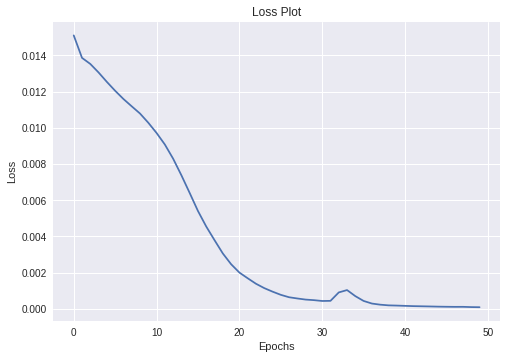

In [28]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [0]:
#The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output
# Stop predicting when the model predicts the end token.
# And store the attention weights for every time step.
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(index_word[predicted_id])

        if index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [0]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))
    
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Prediction Caption: young woman looks for the food at the mountains <end>


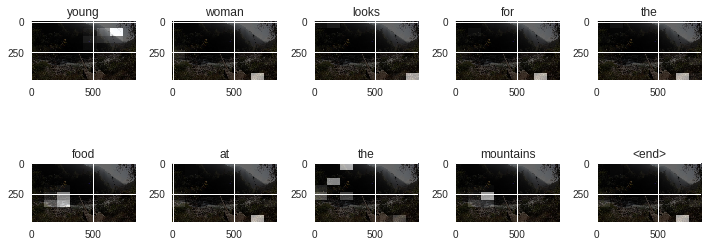

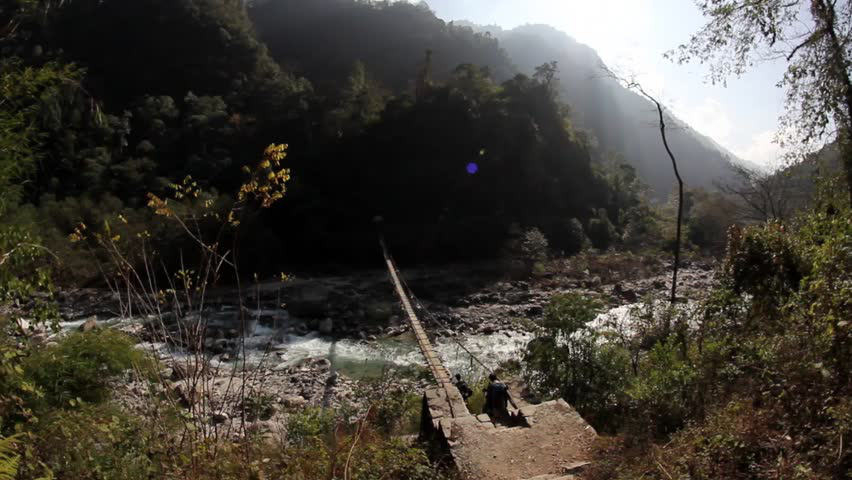

In [67]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid][:-4]
real_caption = ' '.join([index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid][:-4])